In [1]:
import sys
sys.path.append("../python")

from importlib import reload
import h5py
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.patches as pt
import utility_functions
import meshio
import evaluations
import json
import math

from matplotlib.colors import ListedColormap
cmap_blue = ListedColormap(["white", "lightsteelblue", "cornflowerblue", "royalblue", "blue", "navy"])
cmap = ListedColormap(["white", "darkorange", "gold", "navy", "steelblue", "yellowgreen"])
cmap_gray = ListedColormap(["lightgray"])
#cmap = ListedColormap(["white", "cornflowerblue", "blue", "royalblue", "navy", "lightsteelblue"])


In [258]:
parameters_path = "../configs/test.json"
    
file = open(parameters_path)
config = json.load(file)
file.close()

In [259]:
# Set center
center = (config["Geometry"]["Center"]["x"], config["Geometry"]["Center"]["y"])

# Set dipole
position = (config["ModelConfig"]["Dipoles"][0][0],config["ModelConfig"]["Dipoles"][0][1])
rho = config["ModelConfig"]["Dipoles"][0][2]

sample_path = config["Setup"]["OutputPath"] + config["Sampling"]["ResultFile"] + "_0.h5"
fin = h5py.File(sample_path)
samples = np.array( fin['/samples'] )
fin.close()

s_ref = utility_functions.get_dipole(position,center,rho)
sample_dict = {
    "x": samples[0],
    "y": samples[1],
    "rho": samples[2]
}

sample_dataset = az.dict_to_dataset(sample_dict)

36


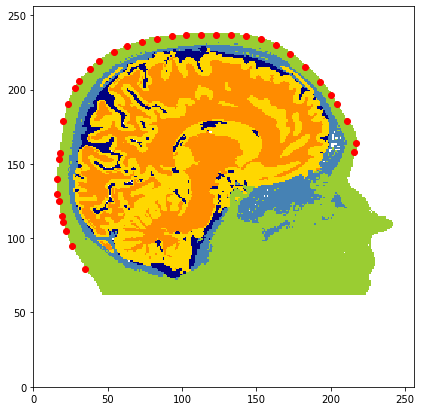

In [260]:
fig, axis = plt.subplots(figsize=(7,7))

mesh = np.load(config[config["Sampling"]["Levels"][0]]["Mesh"])
electrodes = np.array(np.load(config["GeneralLevelConfig"]["Electrodes"])["arr_0"])
print(len(electrodes))

elements = mesh['elements']
nodes = mesh['nodes']
labels = mesh['labels']
gray_probs = mesh['gray_probs']

n = int(math.sqrt(len(elements)))

z = np.ndarray((n,n),float)

for k in range(n):
    for j in range(n):
        z[j,k] = labels[k+n*j]

axis.pcolormesh(z,cmap=cmap)
axis.scatter(electrodes[:,0],electrodes[:,1],c="red")
axis.set_aspect(1)

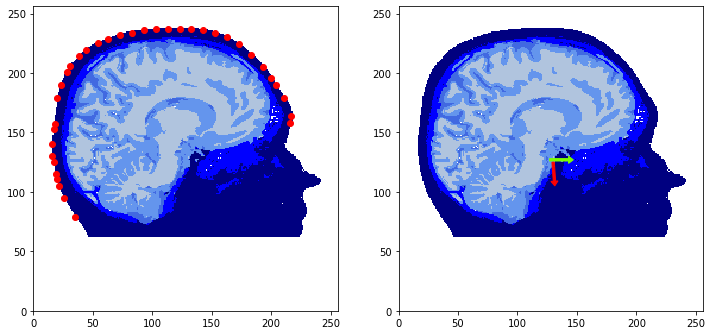

In [261]:
fig, axis = plt.subplots(1,2, figsize=(12,6))

point = (config["ModelConfig"]["Dipoles"][0][0],config["ModelConfig"]["Dipoles"][0][1],config["ModelConfig"]["Dipoles"][0][2])
start = [127,127]

axis[1].pcolormesh(z,cmap=cmap_blue)
axis[1].set_aspect(1)

axis[0].pcolormesh(z,cmap=cmap_blue)
axis[0].scatter(electrodes[:,0],electrodes[:,1],c="red")
axis[0].set_aspect(1)

evaluations.draw_dipole(axis[1], [start[0],start[1],0], "lawngreen", 20)
evaluations.draw_dipole(axis[1], point, "red",20)

plt.show()

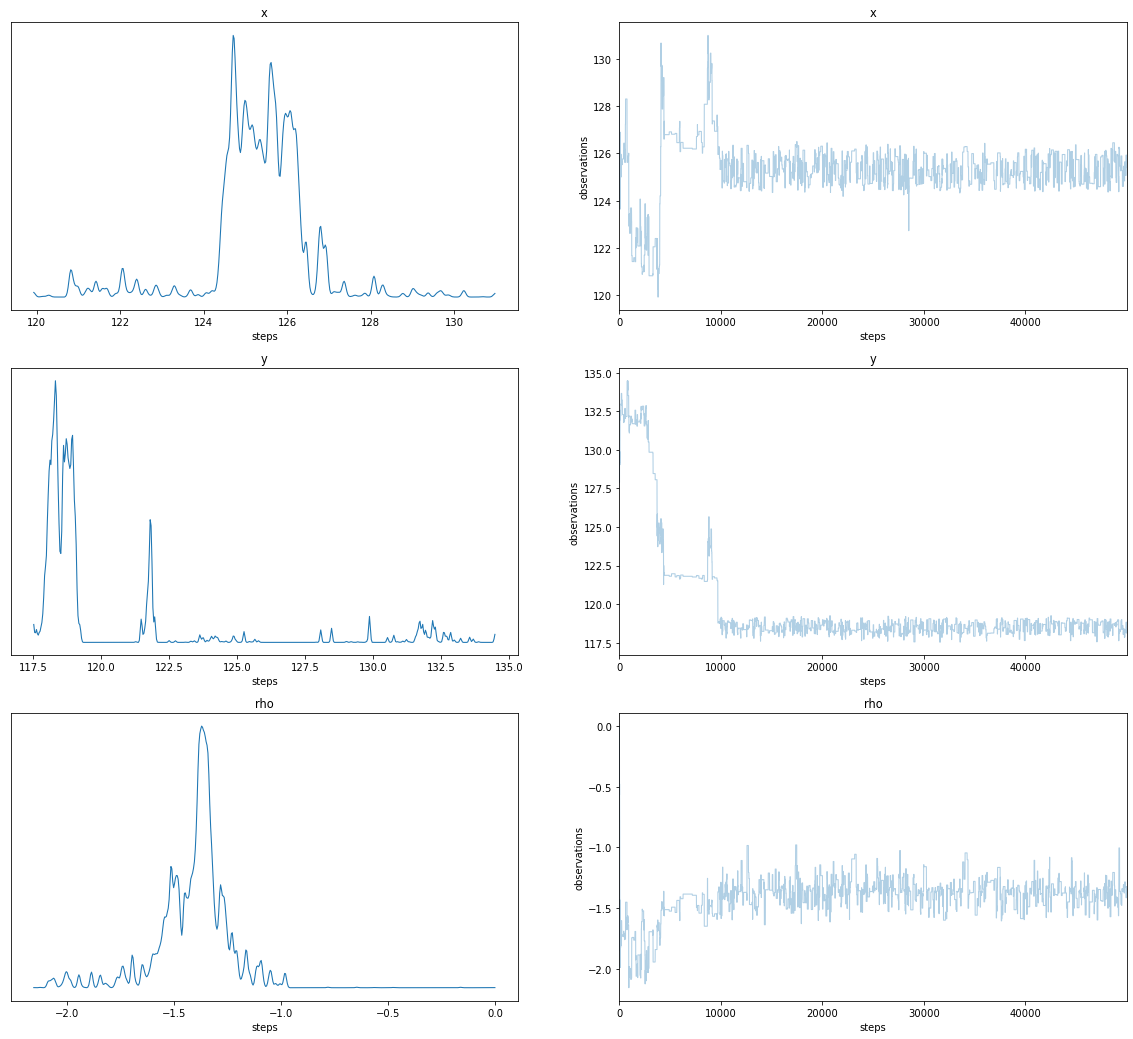

In [262]:
fig, axes = plt.subplots(3, 2, figsize=(20,18))

for ax in axes.flatten():
    ax.set_xlabel('steps')

axes[0,1].set_ylabel('observations')
axes[1,1].set_ylabel('observations')
axes[2,1].set_ylabel('observations')
#axes[0,1].set_ylim(60,130)

p = az.plot_trace(sample_dataset, axes=axes)

(-0.25, 1.0)

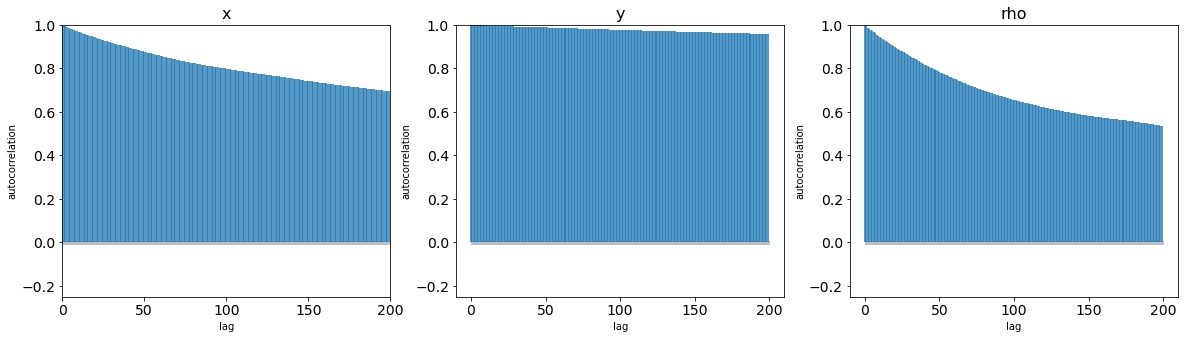

In [263]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

p = az.plot_autocorr(sample_dataset, ax = axes, max_lag=200, combined=True, figsize=(20,4))

axes[0].set_ylabel('autocorrelation')
axes[0].set_xlabel('lag')
axes[1].set_ylabel('autocorrelation')
axes[1].set_xlabel('lag')
axes[2].set_ylabel('autocorrelation')
axes[2].set_xlabel('lag')

axes[0].set_ylim(-0.25,1)
axes[1].set_ylim(-0.25,1)
axes[2].set_ylim(-0.25,1)



In [264]:
bins = np.zeros((n,n))
angles = np.zeros((n,n))
samples_t = np.transpose(samples)
for s in samples_t:
        c = utility_functions.find_next_center(mesh, "hex", s)
        bins[int(c[1]),int(c[0])] += 1
        angles[int(c[1]),int(c[0])] += s[2]

angles = angles/bins
bins = bins/len(samples[0])


/tmp/ipykernel_1546/2913566367.py:9: RuntimeWarning: invalid value encountered in true_divide
  angles = angles/bins


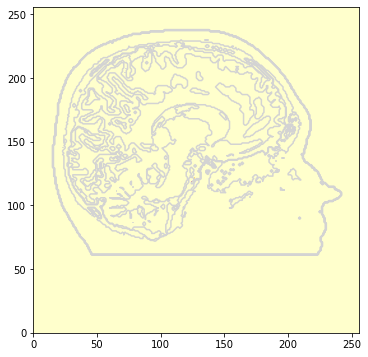

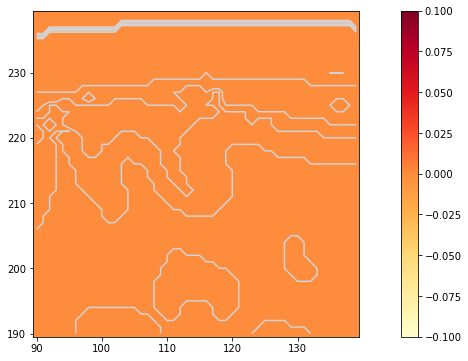

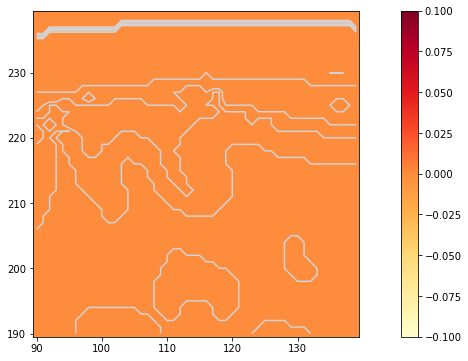

In [265]:
fig, axis = plt.subplots(figsize=(15,6))
fig.subplots_adjust(wspace=.5)

axis.pcolormesh(bins, cmap="YlOrRd")
axis.contour(z, cmap=cmap_gray, levels = [0,1,2,3,4,5])
axis.set_aspect(1)


xmin = 90
xmax = 140
ymin = 190
ymax = 240
x = nodes[xmin:xmax,0]
y = nodes[ymin:ymax,0]

fig, axis = plt.subplots(figsize=(15,6))
fig.subplots_adjust(wspace=.5)

im = axis.pcolormesh(x,y,bins[ymin:ymax,xmin:xmax], cmap="YlOrRd")
plt.colorbar(im)
axis.contour(x,y,z[ymin:ymax,xmin:xmax], cmap=cmap_gray, levels = [0,1,2,3,4,5])
axis.set_aspect(1)

fig, axis = plt.subplots(figsize=(15,6))
fig.subplots_adjust(wspace=.5)

im = axis.pcolormesh(x,y,bins[ymin:ymax,xmin:xmax], cmap="YlOrRd")
plt.colorbar(im)
axis.contour(x,y,z[ymin:ymax,xmin:xmax], cmap=cmap_gray, levels = [0,1,2,3,4,5])
axis.set_aspect(1)

for i in range(n):
    for j in range(n):
        if bins[i,j] > 0.001:
            point = np.array([j,i,angles[i,j]])
            evaluations.draw_dipole(axis, point, "red", 200*bins[i,j], 0.1)



